In [1]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)

import play_song as song
import feature_selection as fs
import NA_outliers as n

In [2]:
df = pd.read_csv('./project_data/out_eda1.csv', 
                 index_col = 'Claim Identifier')

df.head()

,Age at Injury,Alternative Dispute Resolution,Attorney/Representative,Average Weekly Wage,Birth Year,Carrier Name,Carrier Type,Claim Injury Type,County of Injury,COVID-19 Indicator,District Name,Gender,IME-4 Count,Industry Code,Medical Fee Region,WCIO Cause of Injury Code,WCIO Nature of Injury Code,WCIO Part Of Body Code,Zip Code,Number of Dependents,Accident Year,Accident Month,Accident Day,Assembly Year,Assembly Month,Assembly Day,C-2 Year,C-2 Month,C-2 Day,C-3 Date Binary,First Hearing Year
Claim Identifier,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5393875,31.0,571411.0,0.0,0.00,1988.0,12736.0,285367.0,2,3355.0,0.0,44646.0,0.0,0.0,44.0,135885.0,27.0,10.0,62.0,13662.0,1.0,2019.0,12.0,30.0,2020,1,1,2019.0,12.0,31.0,0,0
5393091,46.0,571411.0,1.0,1745.93,1973.0,2862.0,285367.0,4,760.0,0.0,40449.0,1.0,4.0,23.0,135885.0,97.0,49.0,38.0,14569.0,4.0,2019.0,8.0,30.0,2020,1,1,2020.0,1.0,1.0,1,2020
5393889,40.0,571411.0,0.0,1434.80,1979.0,9126.0,285367.0,4,17450.0,0.0,86171.0,0.0,0.0,56.0,85033.0,79.0,7.0,10.0,12589.0,6.0,2019.0,12.0,6.0,2020,1,1,2020.0,1.0,1.0,0,0
5393887,61.0,571411.0,0.0,NaN,1958.0,111144.0,111144.0,2,11530.0,0.0,86171.0,0.0,0.0,62.0,85033.0,16.0,43.0,36.0,12603.0,1.0,2019.0,12.0,30.0,2020,1,1,2019.0,12.0,31.0,0,0
5393863,67.0,571411.0,0.0,0.00,1952.0,14366.0,285367.0,3,60430.0,0.0,60536.0,0.0,0.0,44.0,265981.0,31.0,10.0,38.0,11772.0,5.0,2019.0,12.0,26.0,2020,1,1,2019.0,12.0,31.0,0,0


In [181]:
from sklearn.neighbors import NearestNeighbors
import numpy as np


def ball_tree_impute(df, target, n_neighbors=5):
    # Get all features except the target column
    features = df.columns.drop(target)
    
    # Separate rows with and without missing target values
    missing_mask = df[target].isna()
    non_missing_data = df[~missing_mask]
    missing_data = df[missing_mask]

    # Build a ball tree using all features except the target column
    knn = NearestNeighbors(n_neighbors=n_neighbors, algorithm='ball_tree')
    knn.fit(non_missing_data[features])

    # Find nearest neighbors for rows with missing values
    _, indices = knn.kneighbors(missing_data[features])

    # Impute missing values by averaging the target values of nearest neighbors
    imputed_values = [
        non_missing_data.iloc[neighbor_indices][target].mean() for neighbor_indices in indices
    ]
    
    # Assign the imputed values to the missing target values in the original DataFrame
    df.loc[missing_mask, target] = imputed_values

    return df


def custom_impute(df):
      
    for var_name in df.columns:
        
        if any(word in var_name for word in ['Year', 'Month', 'Day']) and var_name != 'Birth Year':
                df[var_name] = df[var_name].fillna(df[var_name].median())
        
        if var_name == 'Birth Year':
            # Only perform imputation for rows where both columns are not NaN and Birth Year is NaN or 0
            mask = df['Accident Year'].notna() & df['Age at Injury'].notna()
            df.loc[mask & (df[var_name].isna() | (df[var_name] == 0)), 
                    var_name] = df['Accident Year'] - df['Age at Injury']

#             remaining_nans = df['Birth Year'].isna().sum()
#             if remaining_nans > 0:
#                 median = df[var_name].median()
#                 df[var_name] = df[var_name].fillna(median)

        
        # Zip Code
        if var_name == 'Zip Code':
            df[var_name] = df[var_name].fillna(99999)

        # Wage
        if var_name == 'Average Weekly Wage':
            #df[var_name] = df[var_name].fillna(0)
            df[var_name] = ball_tree_impute(df, var_name)


        # for all 'code' variables    
        code_columns = df.filter(regex='Code$', axis=0).columns
        df[code_columns] = df[code_columns].fillna(0)

    return df

def log_transform(X):
    return np.where(X > 0, np.log1p(X), X)


In [9]:
df

,Age at Injury,Alternative Dispute Resolution,Attorney/Representative,Average Weekly Wage,Birth Year,Carrier Name,Carrier Type,Claim Injury Type,County of Injury,COVID-19 Indicator,District Name,Gender,IME-4 Count,Industry Code,Medical Fee Region,WCIO Cause of Injury Code,WCIO Nature of Injury Code,WCIO Part Of Body Code,Zip Code,Number of Dependents,Accident Year,Accident Month,Accident Day,Assembly Year,Assembly Month,Assembly Day,C-2 Year,C-2 Month,C-2 Day,C-3 Date Binary,First Hearing Year
Claim Identifier,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5393875,31.0,571411.0,0.0,0.00,1988.0,12736.0,285367.0,2,3355.0,0.0,44646.0,0.0,0.0,44.0,135885.0,27.0,10.0,62.0,13662.0,1.0,2019.0,12.0,30.0,2020,1,1,2019.0,12.0,31.0,0,0
5393091,46.0,571411.0,1.0,1745.93,1973.0,2862.0,285367.0,4,760.0,0.0,40449.0,1.0,4.0,23.0,135885.0,97.0,49.0,38.0,14569.0,4.0,2019.0,8.0,30.0,2020,1,1,2020.0,1.0,1.0,1,2020
5393889,40.0,571411.0,0.0,1434.80,1979.0,9126.0,285367.0,4,17450.0,0.0,86171.0,0.0,0.0,56.0,85033.0,79.0,7.0,10.0,12589.0,6.0,2019.0,12.0,6.0,2020,1,1,2020.0,1.0,1.0,0,0
5393863,67.0,571411.0,0.0,0.00,1952.0,14366.0,285367.0,3,60430.0,0.0,60536.0,0.0,0.0,44.0,265981.0,31.0,10.0,38.0,11772.0,5.0,2019.0,12.0,26.0,2020,1,1,2019.0,12.0,31.0,0,0
5393848,48.0,571411.0,0.0,0.00,1971.0,12274.0,285367.0,2,15511.0,0.0,44646.0,0.0,0.0,72.0,135885.0,19.0,40.0,36.0,13029.0,1.0,2019.0,12.0,28.0,2020,1,1,2019.0,12.0,31.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6165265,35.0,571411.0,0.0,0.00,1987.0,111144.0,111144.0,2,39618.0,0.0,270778.0,0.0,0.0,56.0,265981.0,45.0,10.0,42.0,10467.0,4.0,2022.0,12.0,14.0,2022,12,30,2022.0,12.0,30.0,0,0
6165285,33.0,571411.0,0.0,0.00,1989.0,2331.0,285367.0,2,43580.0,0.0,270778.0,0.0,0.0,62.0,265981.0,74.0,37.0,35.0,11590.0,6.0,2022.0,12.0,15.0,2022,12,31,2022.0,12.0,31.0,0,0
6165506,61.0,571411.0,0.0,991.08,1961.0,2950.0,285367.0,4,30874.0,0.0,45605.0,1.0,1.0,62.0,85033.0,98.0,80.0,34.0,14227.0,3.0,2022.0,12.0,13.0,2022,12,31,2022.0,12.0,31.0,0,0


In [182]:
custom_impute(df)

ValueError: Found array with 0 sample(s) (shape=(0, 30)) while a minimum of 1 is required by NearestNeighbors.

In [179]:
df.isna().sum()

Age at Injury                     0
Alternative Dispute Resolution    0
Attorney/Representative           0
Average Weekly Wage               0
Birth Year                        0
Carrier Name                      0
Carrier Type                      0
Claim Injury Type                 0
County of Injury                  0
COVID-19 Indicator                0
District Name                     0
Gender                            0
IME-4 Count                       0
Industry Code                     0
Medical Fee Region                0
WCIO Cause of Injury Code         0
WCIO Nature of Injury Code        0
WCIO Part Of Body Code            0
Zip Code                          0
Number of Dependents              0
Accident Year                     0
Accident Month                    0
Accident Day                      0
Assembly Year                     0
Assembly Month                    0
Assembly Day                      0
C-2 Year                          0
C-2 Month                   

In [66]:
## EVAL function

In [3]:
num = ['Age at Injury', 'Average Weekly Wage', 'Birth Year', 'IME-4 Count', 'Number of Dependents',
       'Accident Year', 'Accident Month', 'Accident Day', 'Assembly Year', 'Assembly Month', 'Assembly Day',
       'C-2 Year', 'C-2 Month', 'C-2 Day', 'First Hearing Year']

categ = ['Alternative Dispute Resolution', 'Attorney/Representative', 'Carrier Name', 'Carrier Type',
         'County of Injury', 'COVID-19 Indicator', 'District Name', 'Gender',
         'Industry Code', 'Medical Fee Region', 'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code',
         'WCIO Part Of Body Code', 'Zip Code', 'C-3 Date Binary' ]

In [6]:
df = df.dropna()

In [7]:
from sklearn.metrics import classification_report
from collections import Counter
import time
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from functools import partial


def evaluate_features(df, num, categ, 
                      rfe_features, rfe_model, k=5):
    
    start_time = time.time()
    
    X, y = df.drop(columns=['Claim Injury Type']), df['Claim Injury Type']
    kf = KFold(n_splits=k)
    selected_features = []

    for train_idx, val_idx in kf.split(X):
        
        print(f'------------ FOLD ------------ \n')
        start_time = time.time()
        
        # train & val
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        # Construct the Pipeline 
        
        pipeline = Pipeline([
        ('imputer', FunctionTransformer(partial(custom_impute, target='Average Weekly Wage'), validate=False)),  # Corrected line
        ('log_transform', FunctionTransformer(log_transform, validate=False)),  
        ])
        
        print(X_train.isna().sum())
        
        #song.play_('audio.mp3')
        
        # Fit the pipeline on the training data
        pipeline.fit(X_train, y_train)
        
        # Numerical
        print('----LASSO----')
        lasso = fs.lasso(X_train, y_train, num)
        print('----RFE----')
        # for model in rfe_model: ## FUTURE
        rfe = fs.rfe(X_train, y_train, num, rfe_features, rfe_model)
        print('----CORR----')
        corr = fs.correlation_matrix(X_train, num)
        #print('----VAR----')
        var = fs.var(X_train, num)
        
        # Categorical
        print('----CHI2----')
        chi2 = fs.chi_squared(X_train, y_train, categ)
        print('----MI----')
        mutual_information = fs.mutual_information(X_train, y_train, categ)
        
        
        # Combine selected features from each method
        num_selected = set(lasso).union(rfe, corr, var)
        categ_selected = set(chi2).union(mutual_information)

        # Filter training and validation sets based on selected features
        num_selected = [feature for feature in num_selected if isinstance(feature, str)]
        
        #num_selected = num_selected.to_list()
        categ_selected = list(categ_selected)
        
        X_train_selected = X_train[num_selected + categ_selected]
        X_val_selected = X_val[num_selected + categ_selected]
        
        
        # Train model and record performance
        model = LogisticRegression()
        model.fit(X_train_selected, y_train)
        y_pred = model.predict(X_val_selected)
        
        # Print classification report for current fold
        print('CLASSIFICATION REPORT \n')
        print(classification_report(y_val, y_pred))

        # Save selected features for counting occurrences
        selected_features.append(num_selected + categ_selected)

        # End timing
        end_time1 = time.time()
        elapsed_time1 = end_time1 - start_time
        print(elapsed_time1)
    
    # Count occurrences of each feature across folds
    feature_counts = Counter(np.concatenate(selected_features))
    
    song.play_('audio.mp3')
    # End timing
    end_time2 = time.time()
    elapsed_time2 = end_time2 - start_time
    print(elapsed_time2)
    
    # Select only features that appear in all folds
    final_features = [feature for feature, count in feature_counts.items() if count == k]
    return final_features


------------ FOLD ------------ 



Input #0, wav, from '/var/folders/mm/fxsq_1490x9dd2w76tqvt3kr0000gn/T/tmp60o5qtuz.wav':
  Duration: 00:00:10.00, bitrate: 1536 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 48000 Hz, 2 channels, s16, 1536 kb/s



----LASSO----


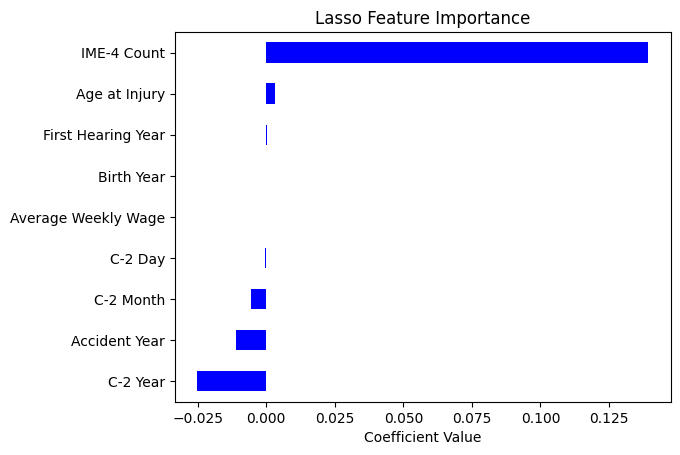

----RFE----
Trying with 12 features: 12 selected features.
Classification Report for 12 features:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00      2130
           2       0.83      1.00      0.91    120829
           3       0.17      0.02      0.03     31228
           4       0.67      0.90      0.77     60551
           5       0.20      0.00      0.00     14513
           6       0.00      0.00      0.00       928
           7       0.00      0.00      0.00        13
           8       0.00      0.00      0.00        99

    accuracy                           0.76    230291
   macro avg       0.23      0.24      0.21    230291
weighted avg       0.65      0.76      0.68    230291

----CORR----


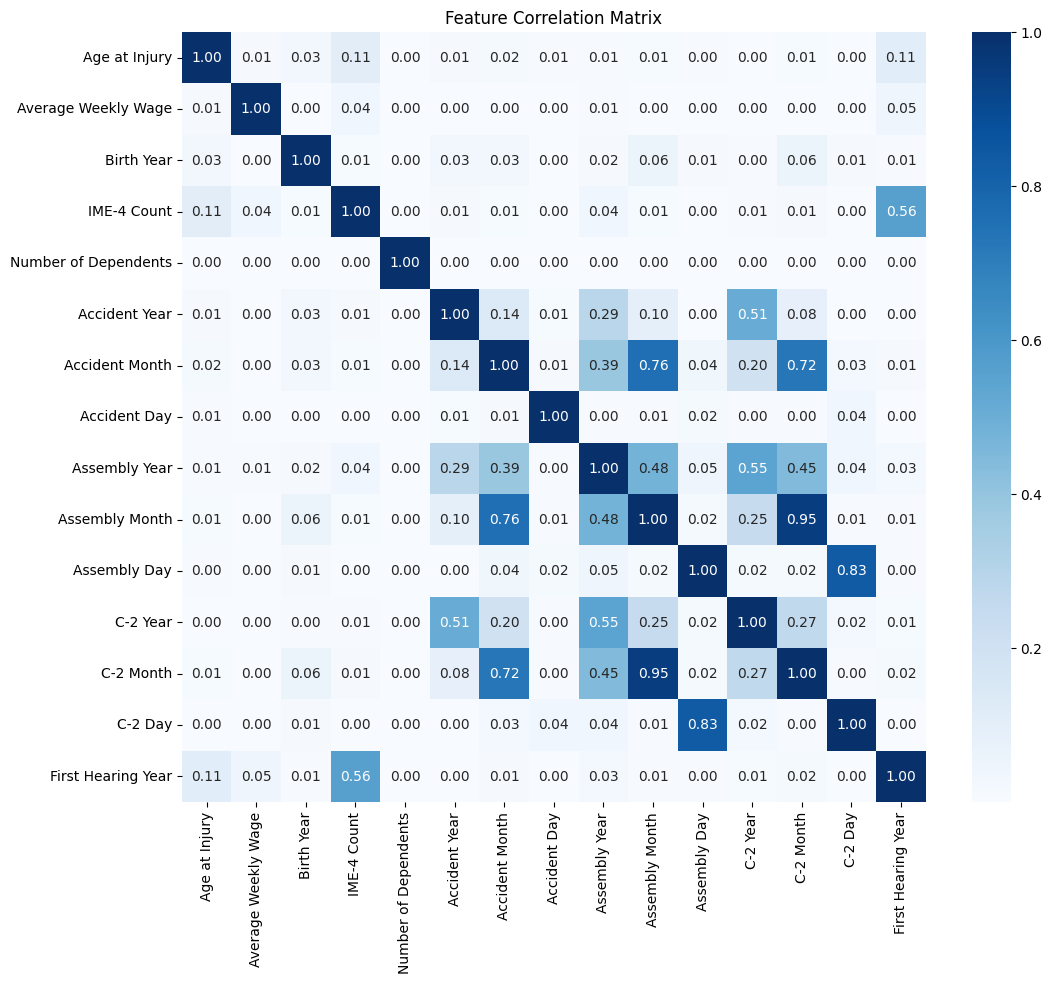

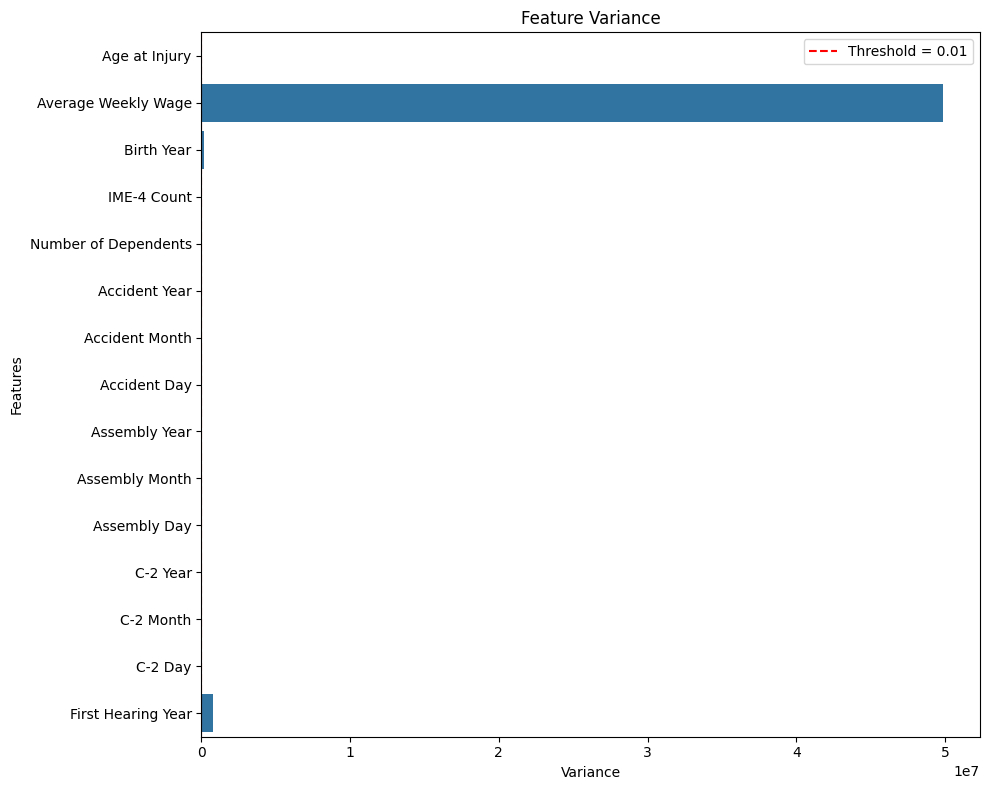

----CHI2----


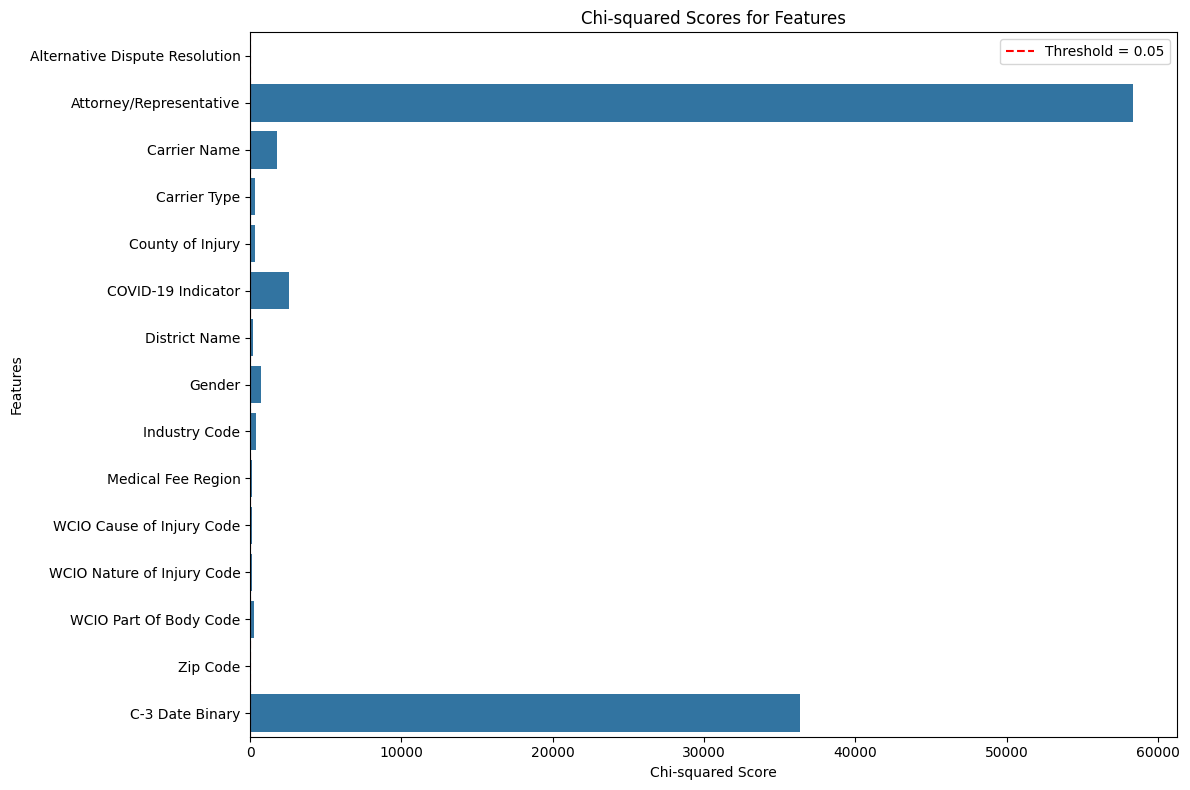

----MI----


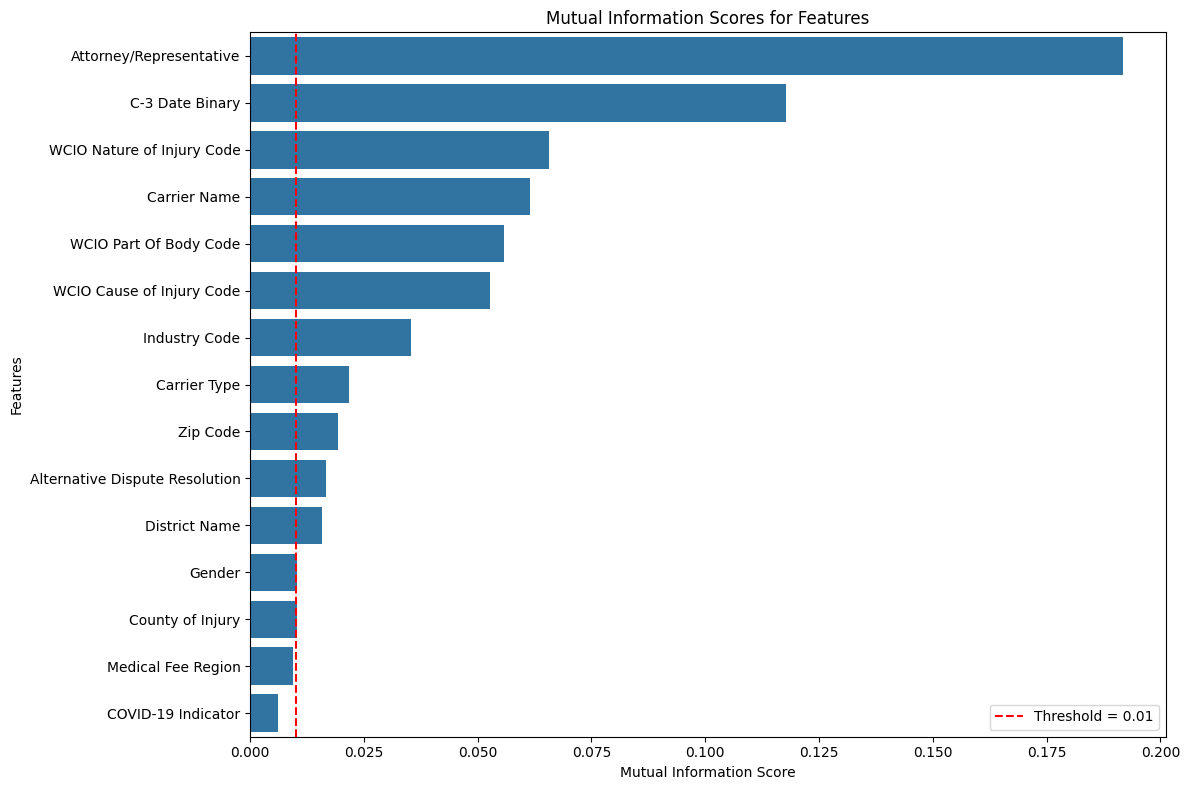

CLASSIFICATION REPORT 

              precision    recall  f1-score   support

           1       0.06      0.00      0.00      2111
           2       0.59      0.99      0.74    112418
           3       0.00      0.00      0.00     25544
           4       0.52      0.33      0.40     61939
           5       0.28      0.03      0.06     25410
           6       0.00      0.00      0.00      2530
           7       0.00      0.00      0.00        71
           8       0.00      0.00      0.00       268

    accuracy                           0.58    230291
   macro avg       0.18      0.17      0.15    230291
weighted avg       0.46      0.58      0.48    230291

85.12492394447327
------------ FOLD ------------ 



Input #0, wav, from '/var/folders/mm/fxsq_1490x9dd2w76tqvt3kr0000gn/T/tmpctr0ygbo.wav':
  Duration: 00:00:10.00, bitrate: 1536 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 48000 Hz, 2 channels, s16, 1536 kb/s



----LASSO----


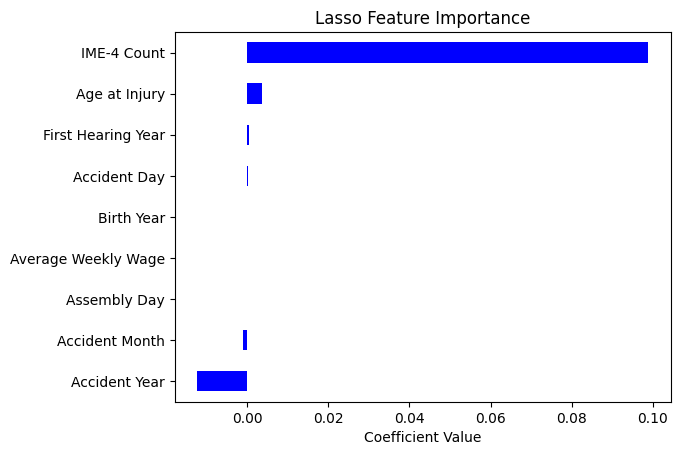

----RFE----
Trying with 12 features: 12 selected features.
Classification Report for 12 features:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00      2111
           2       0.83      1.00      0.91    112418
           3       0.14      0.01      0.01     25544
           4       0.60      0.91      0.72     61939
           5       0.31      0.00      0.00     25410
           6       0.00      0.00      0.00      2530
           7       0.00      0.00      0.00        71
           8       0.00      0.00      0.00       268

    accuracy                           0.73    230291
   macro avg       0.23      0.24      0.20    230291
weighted avg       0.62      0.73      0.64    230291

----CORR----


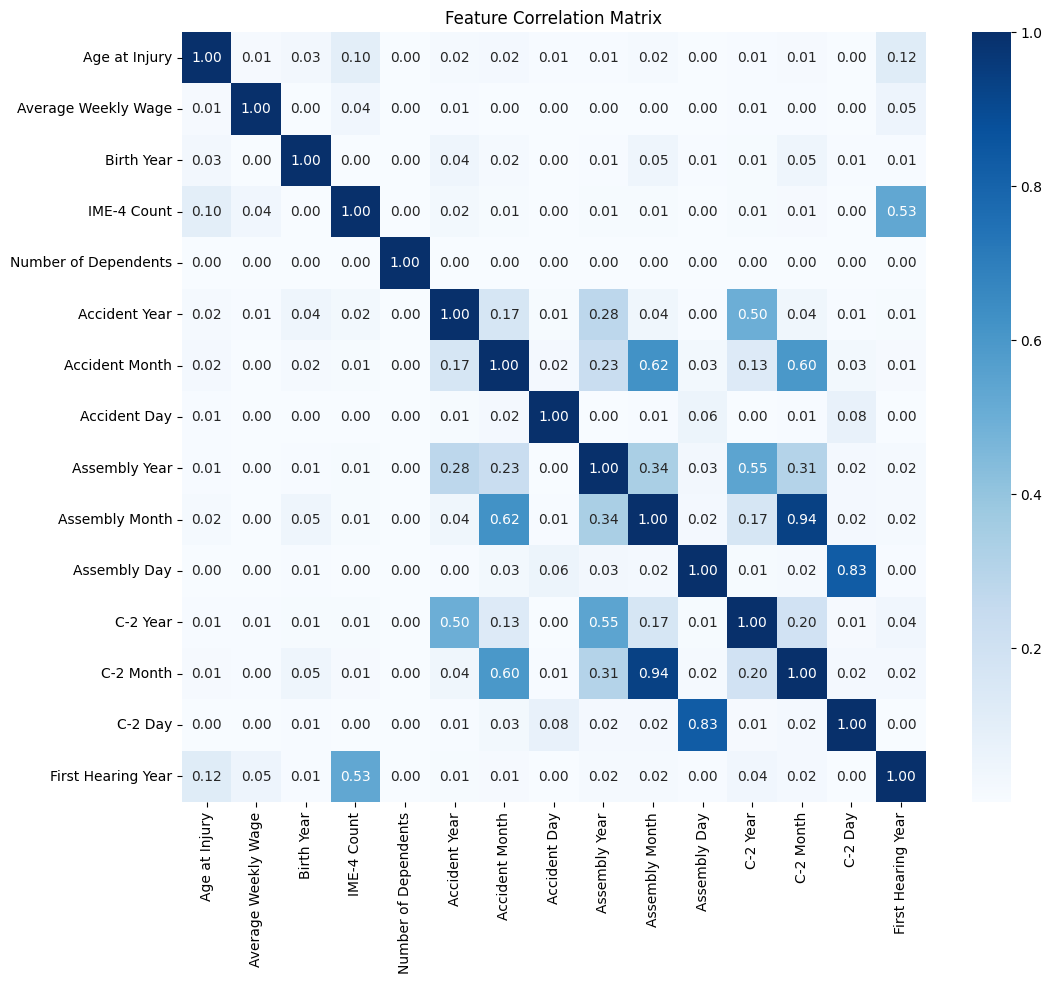

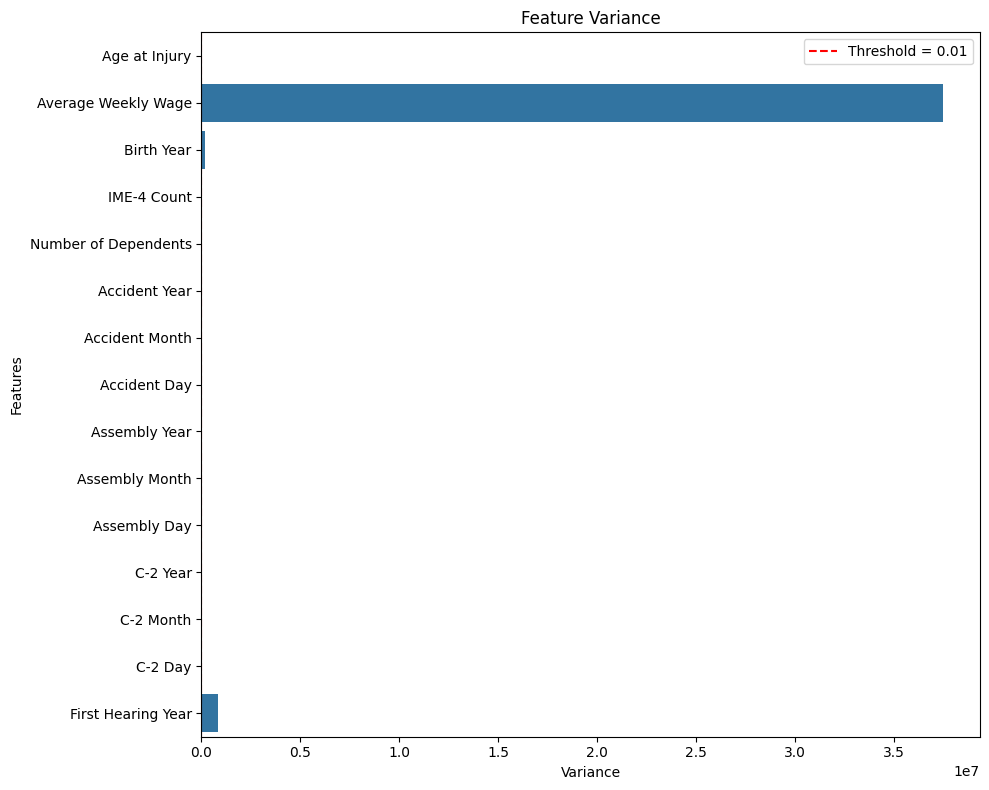

----CHI2----


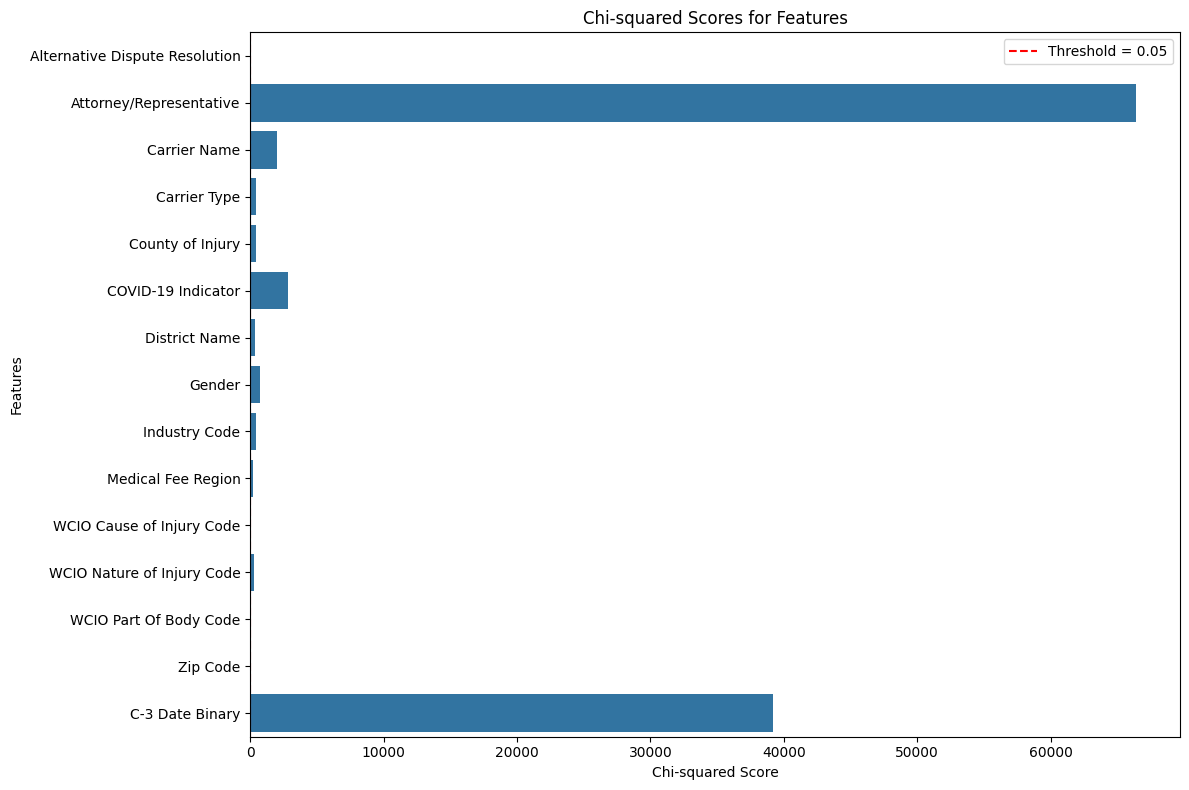

----MI----


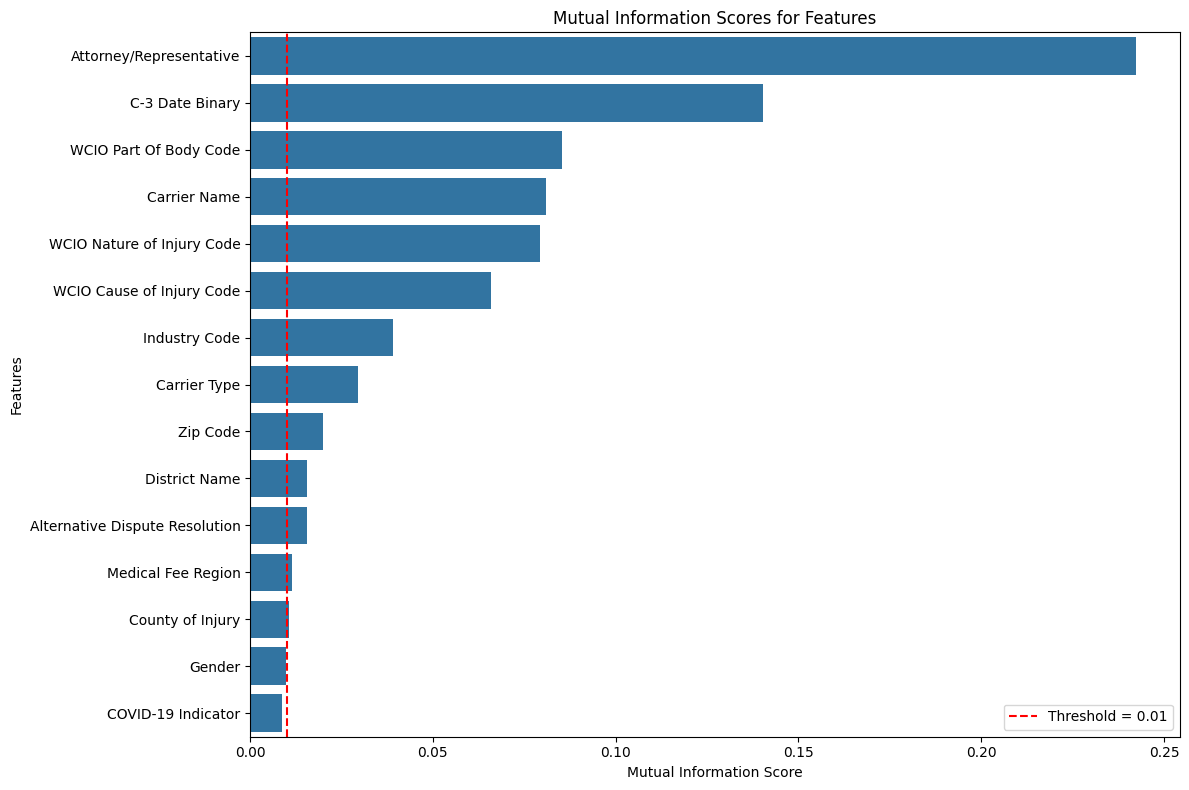

CLASSIFICATION REPORT 

              precision    recall  f1-score   support

           1       0.00      0.00      0.00      2130
           2       0.61      0.98      0.76    120829
           3       0.00      0.00      0.00     31228
           4       0.59      0.32      0.41     60551
           5       0.16      0.06      0.09     14513
           6       0.00      0.00      0.00       928
           7       0.00      0.00      0.00        13
           8       0.00      0.00      0.00        99

    accuracy                           0.60    230291
   macro avg       0.17      0.17      0.16    230291
weighted avg       0.49      0.60      0.51    230291

82.22996187210083


Input #0, wav, from '/var/folders/mm/fxsq_1490x9dd2w76tqvt3kr0000gn/T/tmp7mabbbji.wav':
  Duration: 00:00:10.00, bitrate: 1536 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 48000 Hz, 2 channels, s16, 1536 kb/s


KeyboardInterrupt: 

In [8]:
rfe_features = [12]

evaluate_features(df, num, categ, 
                  rfe_features = rfe_features,
                  rfe_model = LogisticRegression(),
                  k = 2)

IndentationError: expected an indented block after 'if' statement on line 54 (2429252863.py, line 60)

RFE n está a selecionar nenhum número de features (por enquanto), está apenas a mostrar o classification report para cada número de features inputed.

__*5 fold train: LogReg, rfe: LogReg, features=[12,13,14,15]*__

['Accident Year',
 'Number of Dependents',
 'C-2 Day',
 'Assembly Day',
 'First Hearing Year',
 'C-2 Month',
 'IME-4 Count',
 'Assembly Year',
 'Age at Injury',
 'Birth Year',
 'Accident Month',
 'Average Weekly Wage',
 'Accident Day',
 'Assembly Month',
 'C-2 Year',
 'County of Injury',
 'Carrier Name',
 'C-3 Date Binary',
 'Carrier Type',
 'District Name',
 'Zip Code',
 'Alternative Dispute Resolution',
 'Industry Code',
 'Gender',
 'Attorney/Representative',
 'WCIO Nature of Injury Code',
 'WCIO Part Of Body Code',
 'WCIO Cause of Injury Code',
 'COVID-19 Indicator',
 'Medical Fee Region']
 
  TIME: 
 
 __*5 fold train: LogReg, rfe: RF, features=[12]*__
 
 ['Assembly Day',
 'Assembly Month',
 'Assembly Year',
 'First Hearing Year',
 'Age at Injury',
 'C-2 Month',
 'Birth Year',
 'Accident Month',
 'Average Weekly Wage',
 'Accident Year',
 'IME-4 Count',
 'Number of Dependents',
 'Accident Day',
 'C-2 Day',
 'C-2 Year',
 'County of Injury',
 'Carrier Name',
 'C-3 Date Binary',
 'Carrier Type',
 'District Name',
 'Zip Code',
 'Alternative Dispute Resolution',
 'Industry Code',
 'Gender',
 'Attorney/Representative',
 'WCIO Nature of Injury Code',
 'WCIO Part Of Body Code',
 'WCIO Cause of Injury Code',
 'COVID-19 Indicator',
 'Medical Fee Region']
 
 TIME: 28min

In [142]:
for var_name in df.columns:
    if any(word in var_name for word in ['Year', 'Month', 'Day']) and var_name != 'Birth Year':
            df[var_name] = df[var_name].fillna(df[var_name].median())

    if var_name == 'Birth Year':
        # Only perform imputation for rows where both columns are not NaN and Birth Year is NaN or 0
            mask = df['Accident Year'].notna() & df['Age at Injury'].notna()
            df.loc[mask & (df[var_name].isna() | (df[var_name] == 0)), 
                    var_name] = df['Accident Year'] - df['Age at Injury']

            remaining_nans = df[var_name].isna().sum().sum()
            if remaining_nans > 0:
                median = df[var_name].median()
                df[var_name] = df[var_name].fillna(median)

    # Zip Code
    if var_name == 'Zip Code':
        df[var_name] = df[var_name].fillna(99999)

    # Wage
    if var_name == 'Average Weekly Wage':
        df[var_name] = df[var_name].fillna(0)
        #df = ball_tree_impute(df, var_name)


    # for all 'code' variables    
    code_columns = df.filter(regex='Code$', axis=0).columns
    df[code_columns] = df[code_columns].fillna(0)
    

df.isna().sum()

Age at Injury                     0
Alternative Dispute Resolution    0
Attorney/Representative           0
Average Weekly Wage               0
Birth Year                        0
Carrier Name                      0
Carrier Type                      0
Claim Injury Type                 0
County of Injury                  0
COVID-19 Indicator                0
District Name                     0
Gender                            0
IME-4 Count                       0
Industry Code                     0
Medical Fee Region                0
WCIO Cause of Injury Code         0
WCIO Nature of Injury Code        0
WCIO Part Of Body Code            0
Zip Code                          0
Number of Dependents              0
Accident Year                     0
Accident Month                    0
Accident Day                      0
Assembly Year                     0
Assembly Month                    0
Assembly Day                      0
C-2 Year                          0
C-2 Month                   

In [146]:
ball_tree_impute(df, 'Average Weekly Wage')

ValueError: Input X contains NaN.
NearestNeighbors does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

Numerical Features: Lasso, RFE, Variance Threshold, Correlation Matrix, Statistical Tests. <br> <BR>
Categorical Features: Chi-Squared Test, Information Gain, Tree-based Methods, Mutual Information.